In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 데이터 생성

# 시나리오 1: 잘 분리된 동일 밀도의 클러스터
X0, y0 = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# 시나리오 2: 다른 밀도의 클러스터
X1, y1 = make_blobs(n_samples=[100, 800], centers=[(-1, 0), (1, 2)], cluster_std=[0.5, 2.5], random_state=42)

# 시나리오 3: 비선형 클러스터 (반달 모양)
X2, y2 = make_moons(n_samples=200, noise=0.05, random_state=42)

# K-Means 알고리즘 적용
kmeans0 = KMeans(n_clusters=3, random_state=42).fit(X0)
kmeans1 = KMeans(n_clusters=2, random_state=42).fit(X1)
kmeans2 = KMeans(n_clusters=2, random_state=42).fit(X2)

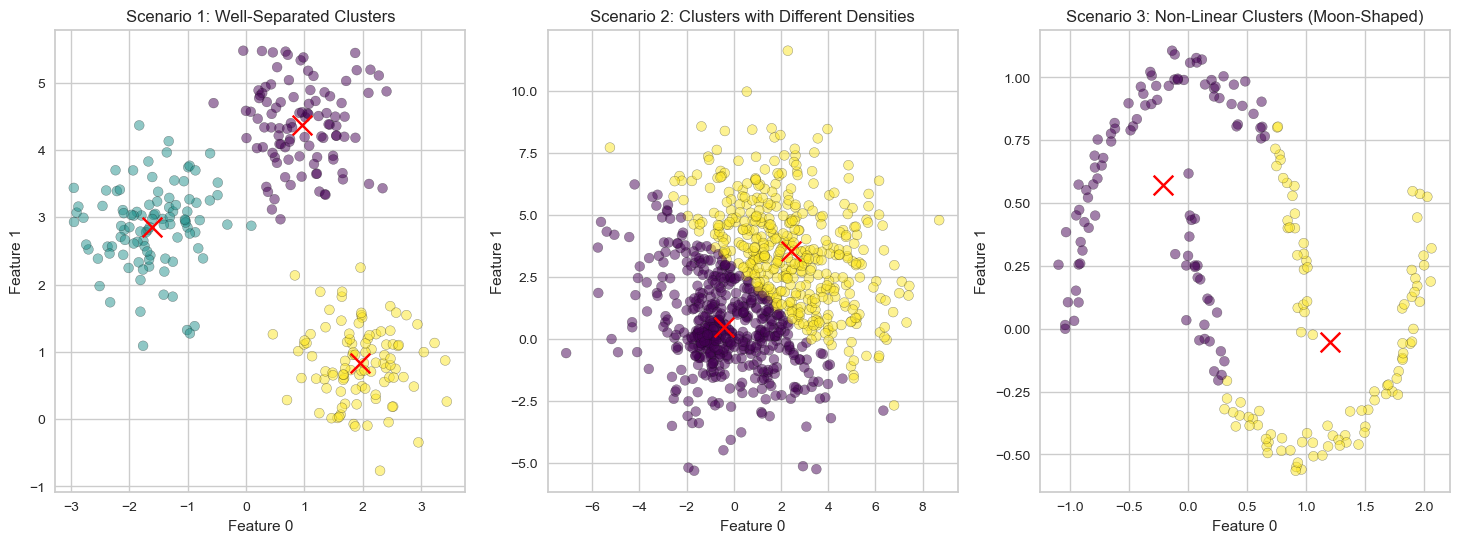

In [4]:
# 시각화 함수
def plot_clusters(X, y, centroids, title):
    plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='viridis', marker='o', edgecolors='k', alpha=0.5)
    plt.scatter(centroids[:,0], centroids[:,1], c='red', s=200, marker='x')
    plt.title(title)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")

# 그래프 그리기
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plot_clusters(X0, kmeans0.labels_, kmeans0.cluster_centers_, "Scenario 1: Well-Separated Clusters")
plt.subplot(1, 3, 2)
plot_clusters(X1, kmeans1.labels_, kmeans1.cluster_centers_, "Scenario 2: Clusters with Different Densities")
plt.subplot(1, 3, 3)
plot_clusters(X2, kmeans2.labels_, kmeans2.cluster_centers_, "Scenario 3: Non-Linear Clusters (Moon-Shaped)")
plt.show()

## K-Means 이용해서 군집 만들기
- feature: 성별, 나이, 수입, 소비
- feature에 대한 이해와 함께 군집 분석을 진행하면 좋다.

In [8]:
df=pd.read_csv('Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [10]:
# 군집화를 위한 feature 정리
df_sp = df.drop('CustomerID', axis=1)
df_sp

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


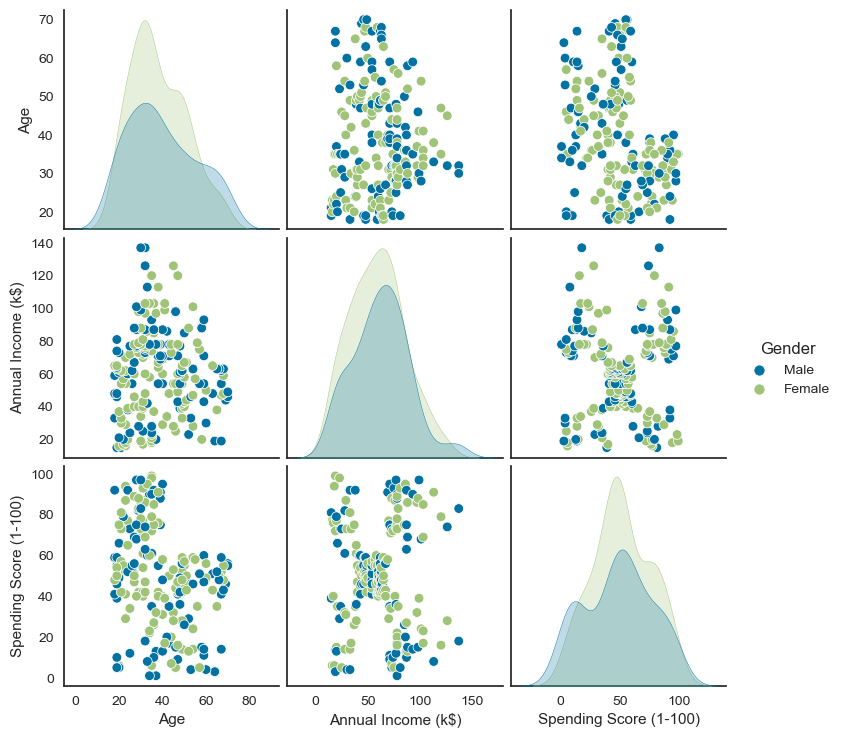

In [11]:
sns.set_style('ticks')
sns.pairplot(df_sp, hue='Gender')
plt.show()

## 군집화를 하기 전 스케일링은 필수적으로 해야한다

In [12]:
# 인코딩작업
df_km = pd.get_dummies(df_sp, columns=['Gender'], drop_first=True)
df_km

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,True
1,21,15,81,True
2,20,16,6,False
3,23,16,77,False
4,31,17,40,False
...,...,...,...,...
195,35,120,79,False
196,45,126,28,False
197,32,126,74,True
198,32,137,18,True


In [13]:
# 스케일링
mns = MinMaxScaler()
df_mns = mns.fit_transform(df_km)

In [14]:
# 컬럼 합쳐보기
df_mns_sp = pd.DataFrame(data=df_mns, columns=df_km.columns)

# minmax 스케일링 작업 완료
df_mns_sp

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,0.019231,0.000000,0.387755,1.0
1,0.057692,0.000000,0.816327,1.0
2,0.038462,0.008197,0.051020,0.0
3,0.096154,0.008197,0.775510,0.0
4,0.250000,0.016393,0.397959,0.0
...,...,...,...,...
195,0.326923,0.860656,0.795918,0.0
196,0.519231,0.909836,0.275510,0.0
197,0.269231,0.909836,0.744898,1.0
198,0.269231,1.000000,0.173469,1.0


## K-Means 불러오기!
- init: 초기 중심점 좌표 설정 방법
- n_clusters: 지정할 클러스터 수
- n_init: 초기 중심점 이동 횟수
- max_iter: 알고리즘 수렴 전 최대 반복 횟수
- random_state: 무작위값 제어 시드

In [15]:
kmeans_model1 = KMeans(n_clusters=3, random_state=111) 
# 고객군의 군집을 3개 정도만 나눠보자!

In [16]:
# K-Means 학습은 fit로 수행
# 스케일링한 값 넣기
kmeans_model1.fit(df_mns_sp)

KMeans(n_clusters=3, random_state=111)

In [17]:
# K-Means 제공 함수
# inertia_: SSE 값 출력
# cluster_centers_: 중심 좌표 출력
# n_iter_: 반복 횟수 출력
# labels_: 군집 레이블 확인(인덱스 기준으로 나열된 것)
print(kmeans_model1.inertia_)
print(kmeans_model1.cluster_centers_)
print(kmeans_model1.n_iter_)
print(kmeans_model1.labels_)

30.11037481210345
[[ 2.00742240e-01  3.66120219e-01  6.80451128e-01 -3.33066907e-16]
 [ 4.19361888e-01  3.87108793e-01  4.84809833e-01  1.00000000e+00]
 [ 5.79020979e-01  3.59165425e-01  3.44712430e-01 -2.77555756e-16]]
5
[1 1 2 0 0 0 2 0 1 0 1 0 2 0 1 1 2 1 1 0 1 1 2 1 2 1 2 1 2 0 1 0 1 1 2 0 2
 0 2 0 2 1 1 0 2 0 2 0 0 0 2 1 0 1 2 1 2 1 0 1 1 1 2 2 1 1 2 2 1 0 1 2 2 2
 1 1 2 1 0 2 1 1 1 2 0 1 2 0 0 2 2 1 1 2 0 1 2 0 1 1 0 2 1 1 1 0 2 1 1 1 1
 0 2 1 0 0 2 2 2 2 1 2 0 1 0 0 1 1 1 1 1 1 0 0 1 0 2 1 1 0 2 1 0 0 1 1 1 0
 2 1 1 1 2 0 2 0 1 0 1 0 2 0 1 0 1 0 1 0 2 1 1 1 1 1 2 0 1 1 1 1 2 0 1 0 2
 1 2 1 2 0 2 0 1 0 2 0 2 1 1 1]


## Elbow chart를 통해서 군집에 대한 평가 진행

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=10, random_state=111))

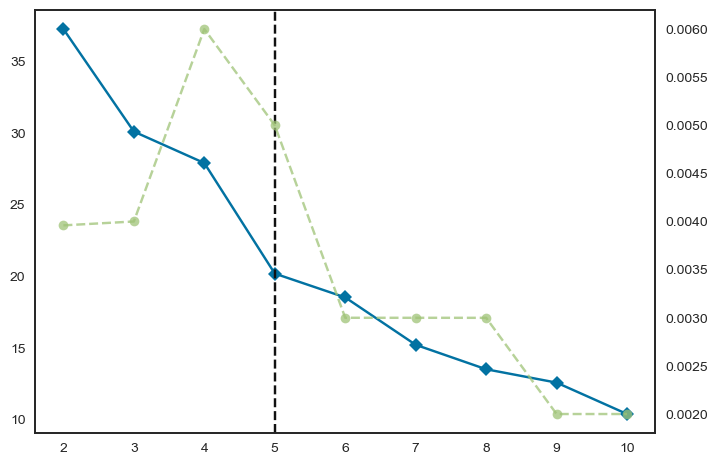

In [18]:
Elbow_ch = KElbowVisualizer(kmeans_model1)
Elbow_ch.fit(df_mns_sp)

## 실루엣계수를 통해서 간단하게 시각화

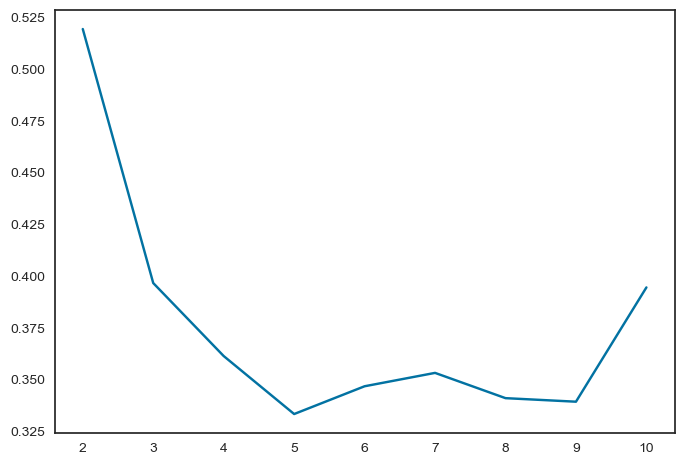

In [20]:
# 반복문을 통해 실루엣계수가 어떤 식으로 변화하는지 체크
KMeans_model1={'random_state':111}

# 실루엣계수 추가
# 군집의 수가 변화하면서 어떤 식으로 값이 함께 변화하는지 같이 살펴보기
sil_coef = []

# 실루엣계수의 그래프 생성
for i in range(2,11):
    kmeans_sil = KMeans(n_clusters=i, **KMeans_model1)
    kmeans_sil.fit(df_mns_sp) # 데이터 학습
    score = silhouette_score(df_mns_sp, kmeans_sil.labels_)
    sil_coef.append(score)

plt.plot(range(2,11), sil_coef)
plt.xticks(range(2,11))
plt.show()

## 군집별로 시각화

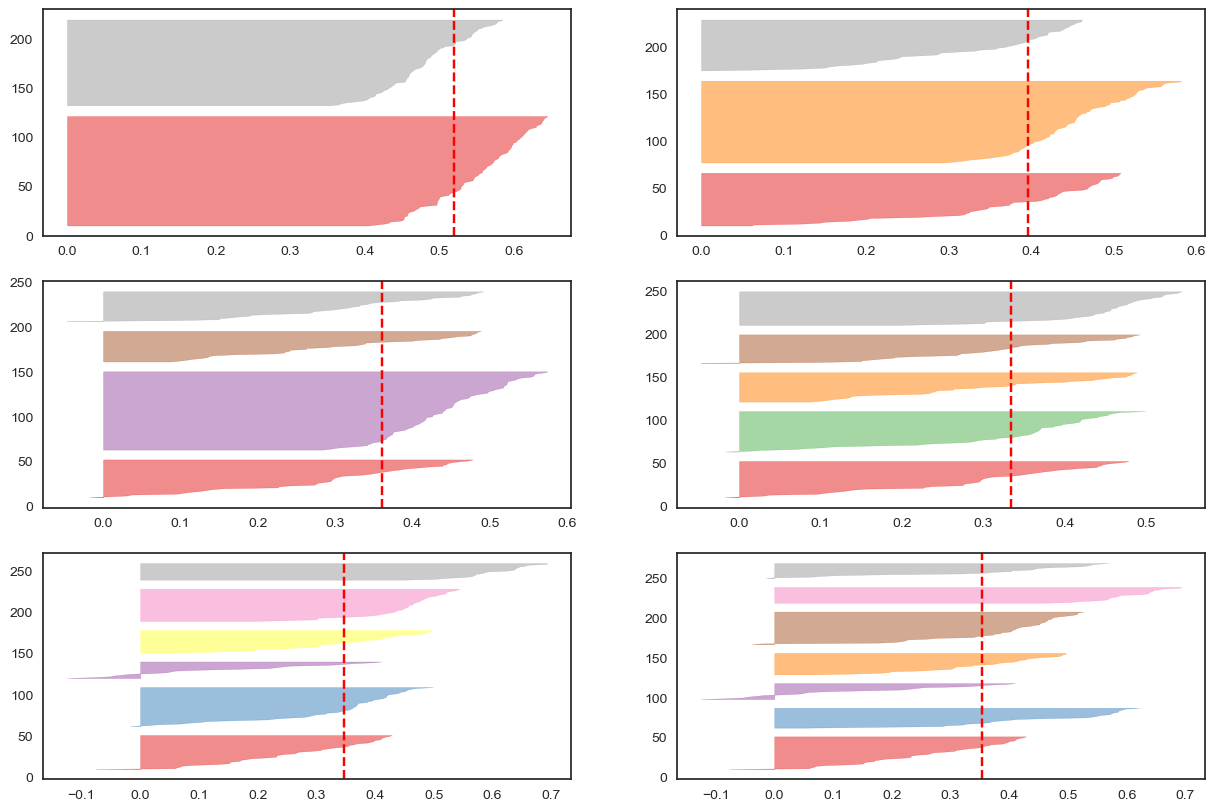

In [21]:
fig, ax = plt.subplots(3,2, figsize=(15,10))

for i in [2,3,4,5,6,7]:
    kmeans_model2 = KMeans(n_clusters=i, random_state=111)
    q, mod = divmod(i,2)
    
    # 실루엣계수 시각화를 군집별로 진행
    visual = SilhouetteVisualizer(kmeans_model2, color='yellowbricks', ax=ax[q-1][mod])
    visual.fit(df_mns_sp) # 데이터셋 학습

In [22]:
kmeans_model2.labels_

array([4, 4, 2, 3, 2, 3, 2, 3, 1, 3, 1, 3, 2, 3, 6, 4, 2, 4, 1, 3, 4, 4,
       2, 4, 2, 4, 2, 4, 2, 3, 1, 3, 1, 4, 2, 3, 2, 3, 2, 3, 0, 4, 1, 3,
       2, 3, 0, 3, 2, 2, 0, 4, 3, 1, 0, 1, 0, 1, 3, 1, 1, 4, 0, 0, 1, 4,
       0, 0, 4, 3, 1, 0, 0, 0, 1, 4, 0, 4, 3, 0, 1, 4, 1, 0, 3, 1, 0, 3,
       3, 0, 0, 4, 1, 0, 2, 4, 0, 3, 1, 4, 3, 0, 1, 4, 1, 3, 0, 1, 1, 1,
       1, 3, 0, 4, 3, 3, 0, 0, 0, 0, 4, 0, 0, 4, 2, 5, 6, 4, 1, 4, 6, 4,
       2, 5, 6, 5, 2, 4, 6, 5, 0, 4, 2, 5, 6, 4, 6, 5, 2, 4, 6, 4, 0, 5,
       0, 5, 6, 5, 6, 5, 0, 5, 6, 5, 6, 5, 6, 5, 0, 4, 6, 4, 6, 4, 0, 5,
       6, 4, 6, 4, 0, 5, 6, 5, 0, 4, 0, 4, 0, 5, 0, 5, 6, 5, 0, 5, 0, 4,
       6, 4])